In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils import resample

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.style as style

import scipy.stats as stats
from scipy.stats import zscore ,skew
from scipy.stats.mstats import normaltest

import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Open the file and read the first few lines to understand its structure
file_path = "/content/drive/MyDrive/Colab Notebooks/5243/bank-additional.csv"

# Reading the first few lines to inspect the file structure
with open(file_path, 'r') as file:
    # next method here will return next item from iterator(file lines)
    first_five_lines = [next(file) for _ in range(5)]

first_five_lines

['"age";"job";"marital";"education";"default";"housing";"loan";"contact";"month";"day_of_week";"duration";"campaign";"pdays";"previous";"poutcome";"emp.var.rate";"cons.price.idx";"cons.conf.idx";"euribor3m";"nr.employed";"y"\n',
 '30;"blue-collar";"married";"basic.9y";"no";"yes";"no";"cellular";"may";"fri";487;2;999;0;"nonexistent";-1.8;92.893;-46.2;1.313;5099.1;"no"\n',
 '39;"services";"single";"high.school";"no";"no";"no";"telephone";"may";"fri";346;4;999;0;"nonexistent";1.1;93.994;-36.4;4.855;5191;"no"\n',
 '25;"services";"married";"high.school";"no";"yes";"no";"telephone";"jun";"wed";227;1;999;0;"nonexistent";1.4;94.465;-41.8;4.962;5228.1;"no"\n',
 '38;"services";"married";"basic.9y";"no";"unknown";"unknown";"telephone";"jun";"fri";17;3;999;0;"nonexistent";1.4;94.465;-41.8;4.959;5228.1;"no"\n']

In [ ]:
# Reading the CSV file into a DataFrame using semicolon as the delimiter
df = pd.read_csv(file_path, delimiter=';')

# Display the first few rows of the DataFrame to confirm successful loading
df.head(5)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [ ]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [ ]:
# check missing value
df.isnull().values.any()

False

In [ ]:
# Encode the target variable
df['y'] = df['y'].map({'yes':1, 'no':0})
# To avoid repeated mapping which will cause assigning NaN to column "y"
df_copy = df.copy()

In [ ]:
df_copy.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0


In [ ]:
# Separate features and target variable
X = df_copy.drop('y', axis = 1)
y = df_copy['y']

In [ ]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
numerical_cols
categorical_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [ ]:
# visualization of nomality of numerical cols (function creation)
def visualization(data, feature):
    style.use('fivethirtyeight')

    # Creating a customized chart. and giving in figsize and other parameters.
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    # creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    ## Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0,0])
    ## Set the title.
    ax1.set_title('Histogram')
    ## plot the histogram.
    sns.histplot(data.loc[: , feature]  , ax = ax1)

    # customizing the QQ_plot.
    ax2 = fig.add_subplot(grid[0,1])
    ## Plotting the QQ-Plot.
    stats.probplot(data.loc[:,feature], plot = ax2)
    ## Set the title.
    ax2.set_title('QQ-Plot')

    ## Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[0,2])
    ## Set title.
    ax3.set_title('Box Plot')
    ## Plotting the box plot.
    sns.boxplot(data.loc[:,feature], orient='v', ax = ax3);


In [ ]:
# visualization

# for i in numerical_cols:
#     visualization(df_copy , i)

In [ ]:
# Removing the outlier values
zscore_data = df_copy[numerical_cols].apply(zscore)
threhold = 3
outliers = (zscore_data.abs() > threhold ).any(axis = 1)
df_copy = df_copy[~outliers]

In [ ]:
# for i in numerical_cols:
#     visualization(df_copy , i)

In [ ]:
# check normality
for cols in numerical_cols:
  ks_statistic, p_value = stats.shapiro(df[cols])
  print(p_value)

5.63094965025088e-33
0.0
0.0
0.0
0.0
0.0
6.991904804610464e-39
3.674064443613238e-41
0.0
0.0


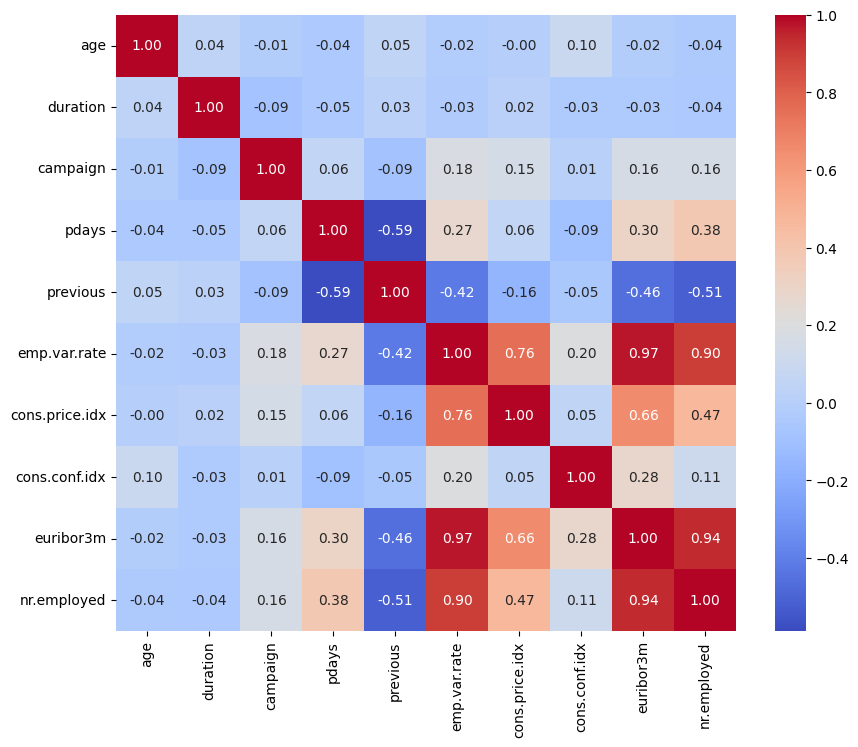

In [ ]:
# check multicollinearity
# Calculating the correlation matrix
corr_matrix = df[numerical_cols].corr()

# Visualizing the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [ ]:
df_with_const = add_constant(df[numerical_cols])
vif_data = pd.DataFrame()
vif_data['feature'] = df_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(df_with_const.values, i) for i in range(df_with_const.shape[1])]
vif_data

,feature,VIF
0,const,516967.917979
1,age,1.016007
2,duration,1.016155
3,campaign,1.048302
4,pdays,1.615604
5,previous,1.823002
6,emp.var.rate,31.945506
7,cons.price.idx,6.329720
8,cons.conf.idx,2.542843
9,euribor3m,62.909035


In [ ]:
high_vif_fea = vif_data[vif_data['VIF'] > 5]['feature']
high_vif_fea_lst = high_vif_fea.tolist()
high_vif_fea_lst.remove('const')
high_vif_fea = high_vif_fea[high_vif_fea != 'const']
high_vif_fea

6       emp.var.rate
7     cons.price.idx
9          euribor3m
10       nr.employed
Name: feature, dtype: object

In [ ]:
# drop features with vif bigger than 10, but we should consider the importance of feature in our dataset.
# As we can see, the emp.var.rate refers to employment variation rate, euribor3m refers to euribor 3 month rate, and nr.employed refers to numer of employees.
# Since all these features are related to social and economic context, not personalize, so we consider drop them.

# drop features with VIF above 10.
numerical_cols = numerical_cols.drop(high_vif_fea_lst)
X_new = X.drop(columns = high_vif_fea)
X_new

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,cons.conf.idx
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-46.2
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,-36.4
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,-41.8
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,17,3,999,0,nonexistent,-41.8
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,30,admin.,married,basic.6y,no,yes,yes,cellular,jul,thu,53,1,999,0,nonexistent,-42.7
4115,39,admin.,married,high.school,no,yes,no,telephone,jul,fri,219,1,999,0,nonexistent,-42.7
4116,27,student,single,high.school,no,no,no,cellular,may,mon,64,2,999,1,failure,-46.2
4117,58,admin.,married,high.school,no,no,no,cellular,aug,fri,528,1,999,0,nonexistent,-36.1


In [ ]:
# Kick out "constant" column
# numerical_cols = [col for col in numerical_cols if col not in  ['age', "campaign", "pdays", "previous"]]

In [ ]:
# Create the preprocessing pipelines for both numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

In [ ]:
# Create the logistic regression pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(solver='liblinear'))])

# Apply cross validation
scores = cross_val_score(pipeline, X_new, y, cv=5, scoring = 'accuracy')   # 5-fold cross-validation
print(scores)

# Initialize the model
logistic_model = pipeline.fit(X_new, y)


[0.90776699 0.90048544 0.91504854 0.91383495 0.91616039]


In [ ]:
type(logistic_model)

sklearn.pipeline.Pipeline

In [ ]:
logistic_model.n_features_in_

16

In [ ]:
# import the additional full dataset and use the model to predict the precision.
file_path = "/content/drive/MyDrive/Colab Notebooks/5243/bank-additional-full.csv"

# Reading the first few lines to inspect the file structure
with open(file_path, 'r') as file:
    # next method here will return next item from iterator(file lines)
    first_five_lines = [next(file) for _ in range(5)]
first_five_lines

['"age";"job";"marital";"education";"default";"housing";"loan";"contact";"month";"day_of_week";"duration";"campaign";"pdays";"previous";"poutcome";"emp.var.rate";"cons.price.idx";"cons.conf.idx";"euribor3m";"nr.employed";"y"\n',
 '56;"housemaid";"married";"basic.4y";"no";"no";"no";"telephone";"may";"mon";261;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"\n',
 '57;"services";"married";"high.school";"unknown";"no";"no";"telephone";"may";"mon";149;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"\n',
 '37;"services";"married";"high.school";"no";"yes";"no";"telephone";"may";"mon";226;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"\n',
 '40;"admin.";"married";"basic.6y";"no";"no";"no";"telephone";"may";"mon";151;1;999;0;"nonexistent";1.1;93.994;-36.4;4.857;5191;"no"\n']

In [ ]:
df_full = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/5243/bank-additional-full.csv", delimiter=';')
df_full.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
# Encode the target variable
df_full['y'] = df_full['y'].map({'yes':1, 'no':0})
# To avoid repeated mapping which will cause assigning NaN to column "y"
df_full_copy = df_full.copy()



In [ ]:
df_full.isnull().values.any()

False

In [ ]:
# Concatenate DataFrames
df_concat = pd.concat([df_copy, df_full_copy])

# Drop duplicates across all columns
df_full_unique = df_concat.drop_duplicates(keep=False)

df_full_unique.shape

(37448, 21)

In [ ]:
# Extract features and response variables
X_full = df_full_unique.drop('y', axis = 1)
X_full = X_full.drop(columns = high_vif_fea)

y_full = df_full_unique['y']

In [ ]:
# predict y value using the additional-full dataset

y_predictions = logistic_model.predict(X_full)

In [ ]:
# Test the model with new data
test_score = logistic_model.score(X_full, y_full)
test_score

0.9058694723349712

In [ ]:
# test if class y is balanced

count_full = y_full == 1
count_full.value_counts()

False    33088
True      4360
Name: y, dtype: int64

In [ ]:
# as we can see, class y is unbalanced, so we consider using confusion matrix to evaluate the performance of model
confusion_matrix(y_full, y_predictions)

array([[32181,   907],
       [ 2618,  1742]])

In [ ]:
# FP: incorrectly identify subscribers
precision_score(y_full, y_predictions)

0.6576066440166101

In [ ]:
# FN: fail to identify potential subscribers
recall_score(y_full, y_predictions)

0.3995412844036697

In [ ]:
f1_score(y_full, y_predictions)

0.49707518904265946

In [ ]:
# Perform Ridge and lasso regression with grid search for hyperparameters
param_grid = {'classifier__C': [0.01, 0.1, 1, 10, 100],
              'classifier__penalty' :['l1', 'l2']
              }

penalized_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver = 'liblinear'))
])

grid_search = GridSearchCV(penalized_pipeline, param_grid, cv=5, scoring='f1')

grid_search.fit(X_new, y)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l2'}
Best cross-validation score: 0.49


In [ ]:
# print out best pipeline
Best_pipeline = Pipeline(steps = [
    ('preprosessor', preprocessor),
    ("classifier", LogisticRegression(solver = 'liblinear', penalty = 'l2', C = 10))
])

Best_log = Best_pipeline.fit(X_new,y)
y_pred = Best_log.predict(X_full)
p = precision_score(y_full, y_pred)
r = recall_score(y_full, y_pred)
f = f1_score(y_full, y_pred)
a = Best_pipeline.score(X_full, y_full)
print(f'accuracy: {a}')
print(f'precision score: {p}')
print(f'recall score: {r}')
print(f'f1 score:{f}')

scores = cross_val_score(Best_pipeline, X_new, y, cv=5, scoring = 'f1')   # 5-fold cross-validation
print(scores)

accuracy: 0.9057626575518052
precision score: 0.6531514928123848
recall score: 0.40642201834862385
f1 score:0.5010603704227343
[0.45070423 0.43356643 0.53146853 0.48571429 0.55483871]


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Resample the dataset
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_new, y)

y_res.value_counts()

0    451
1    451
Name: y, dtype: int64

In [ ]:
# use original pipeline
new_log = pipeline.fit(X_res, y_res)
y_pred_new = new_log.predict(X_full)
p_new = precision_score(y_full, y_pred_new)
r_new = recall_score(y_full, y_pred_new)
f_new = f1_score(y_full, y_pred_new)
a_new = new_log.score(X_full, y_full)
print(f'accuracy: {a_new}')
print(f'precision score: {p_new}')
print(f'recall score: {r_new}')
print(f'f1 score:{f_new}')

accuracy: 0.8491775261696218
precision score: 0.42480149462867817
recall score: 0.8344036697247706
f1 score:0.5629835964097802


In [ ]:
# Perform Ridge and lasso regression with grid search for hyperparameters
param_grid = {'classifier__C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
              'classifier__penalty' :['l1', 'l2']
              }

ridge_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver = 'liblinear'))
])

grid_search_new = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='f1')

grid_search_new.fit(X_res, y_res)

print("Best parameters:", grid_search_new.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_new.best_score_))

Best parameters: {'classifier__C': 1, 'classifier__penalty': 'l1'}
Best cross-validation score: 0.85


In [ ]:
# result out best pipeline after resample
Best_pipeline_2 = Pipeline(steps = [
    ('preprosessor', preprocessor),
    ("classifier", LogisticRegression(solver = 'liblinear', penalty = 'l1', C = 1))
])

Best_log_2 = Best_pipeline_2.fit(X_res,y_res)
y_pred_2 = Best_log_2.predict(X_full)
p_2 = precision_score(y_full, y_pred_2)
r_2 = recall_score(y_full, y_pred_2)
f_2 = f1_score(y_full, y_pred_2)
a_2 = Best_pipeline_2.score(X_full, y_full)
print(f'accuracy: {a_2}')
print(f'precision score: {p_2}')
print(f'recall score: {r_2}')
print(f'f1 score:{f_2}')

scores = cross_val_score(Best_pipeline_2, X_res, y_res, cv=5, scoring = 'f1')   # 5-fold cross-validation
print(scores)

accuracy: 0.8498718222602009
precision score: 0.4264054117098204
recall score: 0.8385321100917431
f1 score:0.5653316839338178
[0.8603352  0.84153005 0.82954545 0.84883721 0.87861272]
